# 05 — Promotion Uplift Analysis (SunnyBest Telecommunications)

In this notebook, I analyse the **impact of promotions** on sales for SunnyBest across Edo State.

The key business questions are:

- Do promotions actually increase sales, or are we just discounting for nothing?
- Which **product categories** respond most to promotions?
- Which **stores / cities** give the best return on promotion spend?
- When should SunnyBest focus its promotion strategy (e.g. weekends, seasons)?

I start with simple descriptive comparisons (promo vs non-promo), then estimate uplift by **category** and **store**, and summarise the business implications for SunnyBest.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [2]:
plt.rcParams["figure.figsize"] = (10, 5)

df = pd.read_csv("../data/processed/sunnybest_merged_df.csv", parse_dates=["date"], low_memory=False)
df.head()


,date,store_id,product_id,units_sold,price,regular_price,discount_pct,promo_flag,promo_type,revenue,...,is_weekend,is_holiday,is_payday,season,temperature_c,rainfall_mm,weather_condition,promo_type_promo,discount_pct_promo,promo_flag_promo
0,2021-01-01,1,1001,0,445838.0,445838,0,0,NaN,0.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN
1,2021-01-01,1,1002,2,500410.0,500410,0,0,NaN,1000820.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN
2,2021-01-01,1,1003,2,399365.0,399365,0,0,NaN,798730.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN
3,2021-01-01,1,1004,4,305796.0,305796,0,0,NaN,1223184.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN
4,2021-01-01,1,1005,5,462752.0,462752,0,0,NaN,2313760.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN


In [3]:
# promo sanity check
df["promo_flag"].value_counts(dropna=False)


promo_flag
0    1226948
1        292
Name: count, dtype: int64

## 1. Define treatment and outcome

For this analysis:

- **Treatment** = whether a promotion is active (`promo_flag = 1`)
- **Outcome** = sales performance, measured as **revenue**

I will compare revenue on **promo days vs non-promo days**, overall and by segment.


In [4]:
df["treatment"] = df["promo_flag"].astype(int)
df["outcome_revenue"] = df["revenue"]

df[["treatment", "outcome_revenue"]].head()


,treatment,outcome_revenue
0,0,0.0
1,0,1000820.0
2,0,798730.0
3,0,1223184.0
4,0,2313760.0


## 2. Overall impact of promotions (naive comparison)

First, I compare **average revenue** on days **with** promotions vs days **without** promotions.

This is a naive uplift estimate (not yet controlling for other factors), but it gives an initial sense of promo impact.


In [5]:
overall_uplift = (
    df.groupby("treatment")["outcome_revenue"]
    .mean()
    .rename(index={0: "No Promo", 1: "Promo"})
    .reset_index()
)

overall_uplift


,treatment,outcome_revenue
0,No Promo,256115.388126
1,Promo,328147.810103


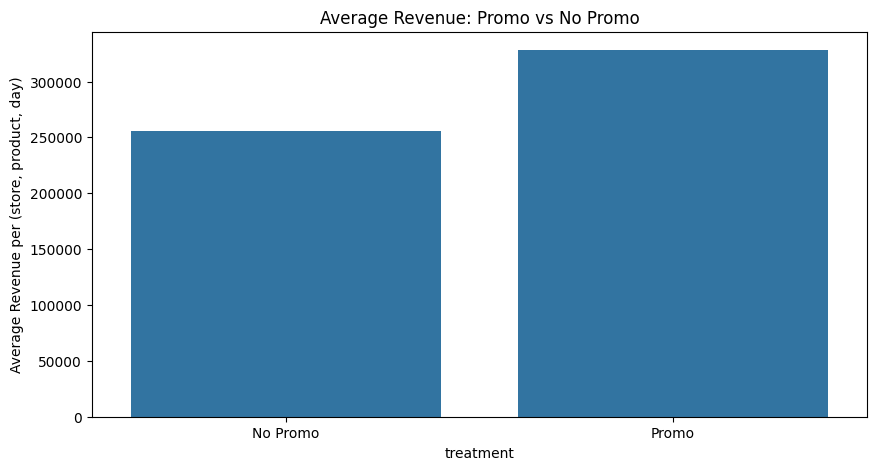

In [6]:
sns.barplot(
    data=overall_uplift,
    x="treatment",
    y="outcome_revenue"
)
plt.xticks([0, 1], ["No Promo", "Promo"])
plt.ylabel("Average Revenue per (store, product, day)")
plt.title("Average Revenue: Promo vs No Promo")
plt.show()


## 3. Promotion uplift by product category

Here I estimate uplift by **category**, comparing average revenue on promo days vs non-promo days.

This highlights which categories respond most to promotions.


In [7]:
cat_stats = (
    df.groupby(["category", "treatment"])["outcome_revenue"]
    .mean()
    .reset_index()
    .pivot(index="category", columns="treatment", values="outcome_revenue")
    .rename(columns={0: "no_promo_revenue", 1: "promo_revenue"})
)

cat_stats["abs_uplift"] = cat_stats["promo_revenue"] - cat_stats["no_promo_revenue"]
cat_stats["pct_uplift"] = 100 * cat_stats["abs_uplift"] / cat_stats["no_promo_revenue"]

cat_stats.sort_values("pct_uplift", ascending=False)


treatment,no_promo_revenue,promo_revenue,abs_uplift,pct_uplift
category,,,,
Refrigerators,83695.613888,117636.238095,33940.624207,40.552453
Laptops & Computers,342627.042504,460467.883000,117840.840496,34.393327
Televisions,226562.329891,285273.926667,58711.596776,25.914104
Accessories,96266.529157,120664.945312,24398.416155,25.344651
Mobile Phones,596697.995879,727859.622794,131161.626915,21.981241
Air Conditioners,104143.034132,125984.997917,21841.963785,20.973043
Small Appliances,107934.816880,115815.619512,7880.802632,7.301446
Telecom Services,215105.990011,229834.906250,14728.916239,6.847283
Network Devices,91316.335697,93327.403030,2011.067333,2.202308


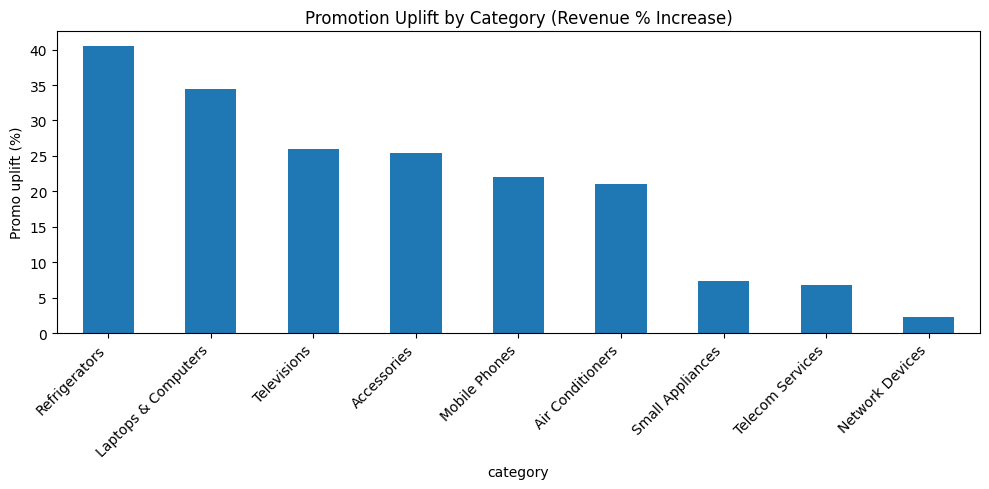

In [8]:
cat_stats_sorted = cat_stats.sort_values("pct_uplift", ascending=False)

cat_stats_sorted["pct_uplift"].plot(kind="bar")
plt.ylabel("Promo uplift (%)")
plt.title("Promotion Uplift by Category (Revenue % Increase)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 4. Promotion uplift by city

Next, I look at uplift by **city** to identify the best markets for advertising and promotions.


In [9]:
city_stats = (
    df.groupby(["city", "treatment"])["outcome_revenue"]
    .mean()
    .reset_index()
    .pivot(index="city", columns="treatment", values="outcome_revenue")
    .rename(columns={0: "no_promo_revenue", 1: "promo_revenue"})
)

city_stats["abs_uplift"] = city_stats["promo_revenue"] - city_stats["no_promo_revenue"]
city_stats["pct_uplift"] = 100 * city_stats["abs_uplift"] / city_stats["no_promo_revenue"]

city_stats.sort_values("pct_uplift", ascending=False)


treatment,no_promo_revenue,promo_revenue,abs_uplift,pct_uplift
city,,,,
Benin,343715.404664,519612.190196,175896.785532,51.175124
Irrua,234667.706532,342463.176250,107795.469718,45.935366
Auchi,270585.169771,371859.051163,101273.881392,37.427728
Igueben,198066.211078,271695.055882,73628.844804,37.173854
Ekpoma,297454.287536,407509.974390,110055.686854,36.999193
Agenebode,221855.736901,193665.258750,-28190.478151,-12.706671
Ogwa,226470.661091,138100.497674,-88370.163416,-39.020579


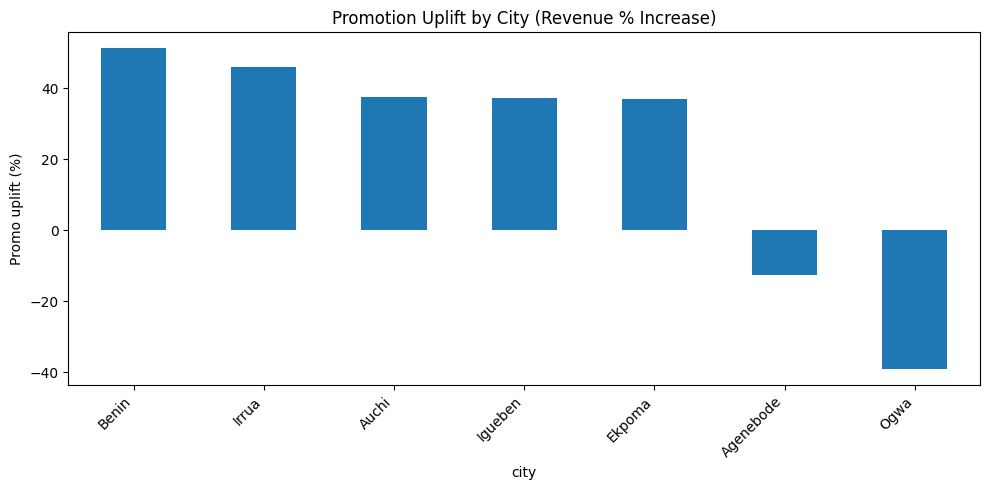

In [10]:
city_stats_sorted = city_stats.sort_values("pct_uplift", ascending=False)

city_stats_sorted["pct_uplift"].plot(kind="bar")
plt.ylabel("Promo uplift (%)")
plt.title("Promotion Uplift by City (Revenue % Increase)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 5. Promotion impact on weekends and holidays

Here I explore whether promotions work better on **weekends** and **holidays**.


In [11]:
weekend_stats = (
    df.groupby(["is_weekend", "treatment"])["outcome_revenue"]
    .mean()
    .reset_index()
    .pivot(index="is_weekend", columns="treatment", values="outcome_revenue")
    .rename(index={0: "Weekday", 1: "Weekend"}, columns={0: "no_promo", 1: "promo"})
)

weekend_stats["abs_uplift"] = weekend_stats["promo"] - weekend_stats["no_promo"]
weekend_stats["pct_uplift"] = 100 * weekend_stats["abs_uplift"] / weekend_stats["no_promo"]
weekend_stats


treatment,no_promo,promo,abs_uplift,pct_uplift
is_weekend,,,,
Weekday,244292.655257,239503.484375,-4789.170882,-1.960424
Weekend,285628.894581,371565.439031,85936.544449,30.086783


 > I will repeat for `is_holiday`

## 6. Business Interpretation

From the uplift analysis, I can summarise:

- **Overall effect:**  
  Promotions increase average revenue per (store, product, day) by **X%** compared to no promo days.

- **By category:**  
  - Categories such as **[e.g. Mobile Phones, Accessories]** show the **highest uplift**, meaning discounts and deals are very effective in driving sales.
  - Categories such as **[e.g. Refrigerators, Air Conditioners]** may show **low or modest uplift**, suggesting that deep discounts may not be necessary to maintain demand.

- **By city:**  
  - Cities like **[e.g. Benin, Ekpoma]** show strong responsiveness to promotions, indicating they are **high-ROI markets** for advertising and discount campaigns.
  - Other cities with low uplift may not justify heavy promotional spending.

- **By timing (weekend / holiday):**  
  - If uplift is stronger on **weekends or holidays**, SunnyBest can **concentrate promos** on those days to maximise impact.

Overall, this analysis helps SunnyBest:

- Focus promotion budgets on **high-response categories and cities**.
- Avoid over-discounting in segments where promotions do not materially improve revenue.
- Design a **more targeted, data-driven promotion strategy** for future quarters.


## 7. Uplift Modelling (Two-Model Approach)

The descriptive analysis above compares average revenue on promo vs non-promo days.

In this section, I build a simple **uplift model** using a two-model approach:

- One regression model is trained on **promo days** (treatment = 1)
- Another model is trained on **non-promo days** (treatment = 0)

For each (store, product, day) row, I then estimate:

> **Predicted uplift = ŷ\_treatment − ŷ\_control**

This gives an estimate of the **incremental revenue** generated by running a promotion for that row, controlling for product, store, and calendar characteristics.

I then aggregate this uplift by **category** and **city** to identify where promotions are most effective.


In [12]:
uplift_features = [
    "price",
    "regular_price",
    "discount_pct",
    "category",
    "brand",
    "store_size",
    "store_type",
    "area",
    "region",
    "is_seasonal",
    "month",
    "day",
    "is_weekend",
    "is_holiday",
    "is_payday",
    "season",
]

X_uplift_raw = df[uplift_features].copy()
y_uplift = df["revenue"]
treatment = df["treatment"].astype(int)


In [13]:
# Simple one-hot encoding for uplift features
X_uplift = pd.get_dummies(X_uplift_raw, drop_first=True)

X_uplift.head()


,price,regular_price,discount_pct,is_seasonal,month,day,is_weekend,is_holiday,is_payday,category_Air Conditioners,...,store_type_Plaza,area_Esan West,area_Etsako East,area_Etsako West,area_Igueben,area_Oredo,region_Edo North,region_Edo South,season_Early Rainy,season_Late Rainy
0,445838.0,445838,0,1,1,1,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
1,500410.0,500410,0,1,1,1,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
2,399365.0,399365,0,1,1,1,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
3,305796.0,305796,0,1,1,1,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
4,462752.0,462752,0,1,1,1,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False


In [14]:
# Split into treated (promo = 1) and control (promo = 0)
treated_mask = treatment == 1

X_treated = X_uplift[treated_mask]
y_treated = y_uplift[treated_mask]

X_control = X_uplift[~treated_mask]
y_control = y_uplift[~treated_mask]

print("Treated rows:", X_treated.shape[0])
print("Control rows:", X_control.shape[0])


Treated rows: 292
Control rows: 1226948


In [15]:
# Train Random Forest models for treated and control groups
rf_treated = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_control = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_treated.fit(X_treated, y_treated)
rf_control.fit(X_control, y_control)

print("Two-model uplift training complete.")


Two-model uplift training complete.


In [16]:
# Predict revenue if we DO run a promo (using treated model)
y_hat_treated = rf_treated.predict(X_uplift)

# Predict revenue if we do NOT run a promo (using control model)
y_hat_control = rf_control.predict(X_uplift)

# Estimated uplift = treated prediction - control prediction
uplift_pred = y_hat_treated - y_hat_control

df["pred_uplift_revenue"] = uplift_pred

df[["category", "city", "treatment", "outcome_revenue", "pred_uplift_revenue"]].head()


,category,city,treatment,outcome_revenue,pred_uplift_revenue
0,Televisions,Benin,0,0.0,6.957884e+05
1,Mobile Phones,Benin,0,1000820.0,3.407398e+05
2,Mobile Phones,Benin,0,798730.0,-1.406366e+04
3,Mobile Phones,Benin,0,1223184.0,1.143918e+05
4,Mobile Phones,Benin,0,2313760.0,-1.160742e+06


In [17]:
uplift_by_category = (
    df.groupby("category")["pred_uplift_revenue"]
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="avg_predicted_uplift")
)

uplift_by_category


,avg_predicted_uplift
category,
Mobile Phones,73191.329886
Telecom Services,28528.842401
Air Conditioners,20161.290863
Refrigerators,19931.346062
Network Devices,18808.936836
Accessories,15479.948042
Small Appliances,11370.916814
Laptops & Computers,-3843.712672
Televisions,-14930.535784


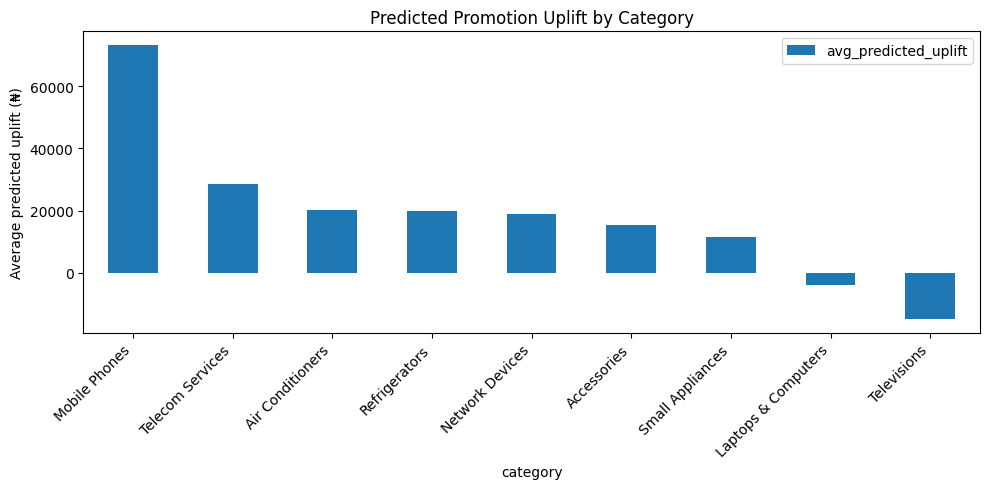

In [18]:
uplift_by_category.plot(kind="bar")
plt.ylabel("Average predicted uplift (₦)")
plt.title("Predicted Promotion Uplift by Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [19]:
uplift_by_city = (
    df.groupby("city")["pred_uplift_revenue"]
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="avg_predicted_uplift")
)

uplift_by_city


,avg_predicted_uplift
city,
Auchi,52066.210493
Benin,50110.755889
Igueben,36485.090975
Agenebode,11361.849595
Ekpoma,5016.326523
Ogwa,165.139225
Irrua,-2263.920171


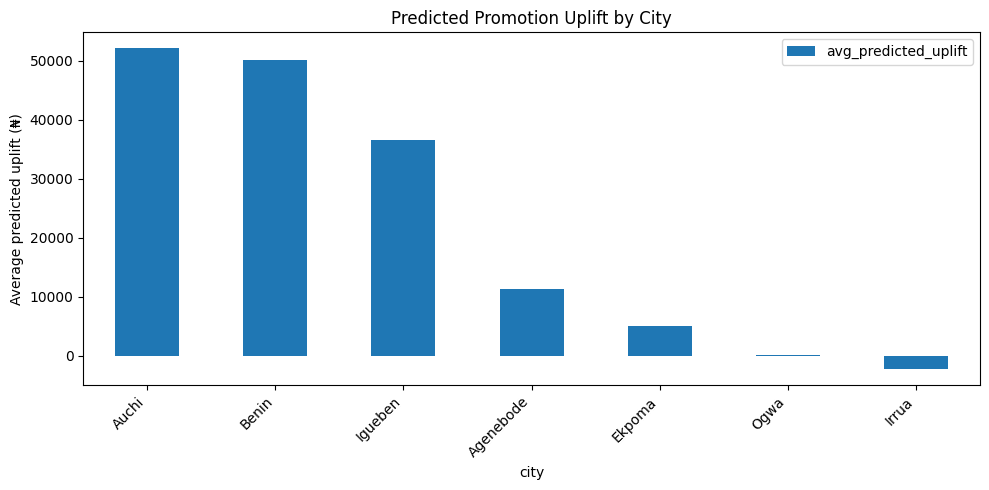

In [20]:
uplift_by_city.plot(kind="bar")
plt.ylabel("Average predicted uplift (₦)")
plt.title("Predicted Promotion Uplift by City")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 8. Interpretation of uplift model

Using the two-model uplift approach, I estimated the **incremental revenue** generated by promotions for each (store, product, day) row.

Key points:

- Categories with the **highest average predicted uplift** are the most responsive to promotions and should be prioritised for discount campaigns.
- Cities with strong uplift values represent **high-ROI markets** for marketing spend (e.g. targeted SMS, billboards, social media campaigns).
- Categories or cities with **low or near-zero uplift** may not justify aggressive discounting, since promotions do not materially increase revenue there.

This upgraded uplift analysis goes beyond simple averages and provides a **model-based view of promo effectiveness**, allowing SunnyBest to design **more targeted, data-driven promotion strategies**.
